# The Parity Problem - RNN in Theano

**Kyu Cho**  
**11/12/2016** 

# Application
- Data transmission in communication systems  
- Source: sends a bitstream to a receiver  
- Suppose one bit gets reversed - how can we detect this?  
- One simple way: add a parity bit to the end of each message  
- Require that each message has even number of 1s  
- If message has odd nmber of 1s, add a parity bit 1 to make total even  
- If message has even number of 1s, add a parity bit 0 so total stays even  
- Receiver checks number of 1s in traansmitted message - if it's odd -> there's aan error  

# Solve it using RNN
- Idea: keep track of some state  
- State:  
    + If 0 and see 1, switch to 1  
    + If 1 and see 1, switch to 0  
    + If see 0, keep the same state  

# Example
Input/Trget/Sequence Targets:  
0000     0      0000  
0001     1      0001  
0010     1      0011  
0011     0      0010  
0100     1      0111  
0101     0      0110  
0110     0      0100  
0111     1      0101  
...     ....     ....  

In [1]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# this function takes number of bits and generate all possible combinations
def all_parity_pairs(nbit):
    N = 2**nbit
    remainder = 100 - (N % 100)
    Ntotal = N + remainder
    X = np.zeros((Ntotal, nbit))
    Y = np.zeros(Ntotal)
    
    for ii in xrange(Ntotal):
        i = ii % N
        
        # now generate the ith sample
        for j in xrange(nbit):
        
            if i % (2**(j+1)) != 0:
                i -= 2**j
                X[ii,j] = 1
        Y[ii] = X[ii].sum() % 2
    return X, Y

In [3]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [6]:
class SimpleRNN:
    def __init__(self, M):
        self.M = M # hidden layer size

    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] # 1, X is 4100 x 12 x 1, 
        K = len(set(Y.flatten())) # 2, get the length of unquie numbers
        N = len(Y) # 12
        M = self.M # 4
        self.f = activation

        # initial weights
        Wx = init_weight(D, M) # 1 x 4
        Wh = init_weight(M, M) # 4 x 4
        bh = np.zeros(M) # 4
        h0 = np.zeros(M) # 4
        Wo = init_weight(M, K) # 4 x 2
        bo = np.zeros(K) # 2
      
        # make them theano shared
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        thX = T.fmatrix('X')
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.flatten(T.nnet.softmax(h_t.dot(self.Wo) + self.bo), outdim=1)
            return h_t, y_t

        # scan function only runs whenever thX value is filled
        [h, y], _ = theano.scan(
            fn = recurrence,
            outputs_info = [self.h0, None],
            sequences = thX, # a sequence, will go through every bit
            n_steps = thX.shape[0],
        )

        py_x = y # (no. of bit, 1, no. of total unique number)   ex) (12, 1, 2)
        prediction = T.argmax(py_x, axis=1) # list with len. 12 (argmax 1 returns idx. of max number in every row) 

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(
            inputs = [thX], 
            outputs = prediction
        )
        self.train_op = theano.function(
            inputs = [thX, thY],
            outputs = [cost, prediction, y],
            updates = updates
        )
        
        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            
            for j in xrange(N): # 0 to 11
                c, p, rout = self.train_op(X[j], Y[j]) # p is index either 0 or 1
                cost += c
                
                if p[-1] == Y[j,-1]: # '-1' only care about the final bit
                    n_correct += 1

            print "y:", rout.shape # (no. of bit, 1, no. of outputs)   ex) (12, 2)
            print "i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N)
            costs.append(cost)

        if show_fig:
            plt.plot(costs)
            plt.show()

input X: 
[[[ 0.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 1.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 1.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 ..., 
 [[ 1.]
  [ 0.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 1.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 1.]
  [ 1.]
  [ 0.]
  ..., 
  [ 0.]
  [ 0.]
  [ 0.]]]
input Y: 
[[0 0 0 ..., 0 0 0]
 [1 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 [1 0 0 ..., 0 0 0]]
y: (12, 2)
i: 0 cost: 2847.33660549 classification rate: 0.486585365854
y: (12, 2)
i: 1 cost: 2839.7526941 classification rate: 0.50243902439
y: (12, 2)
i: 2 cost: 2834.37458298 classification rate: 0.5
y: (12, 2)
i: 3 cost: 2831.43028268 classification rate: 0.499512195122
y: (12, 2)
i: 4 cost: 2829.38234907 classification rate: 0.5
y: (12, 2)
i: 5 cost: 2829.17846277 classification rate: 0.499512195122
y: (12, 2)
i: 6 cost: 2828.76992415 classification rate: 0.5
y: (12, 2)
i: 7 cost: 2828.1

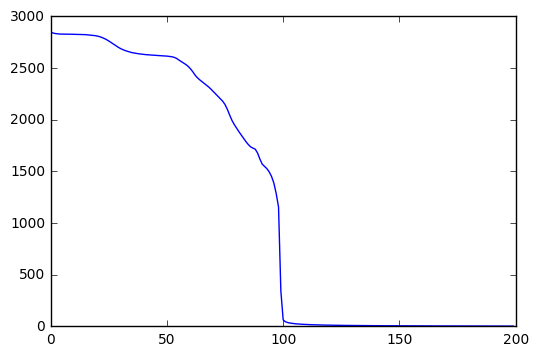

In [7]:
def parity(B=12, learning_rate=10e-5, epochs=200):
    X, Y = all_parity_pairs(B)
    N, t = X.shape
#     print "Input: \n", X[:5][:5] 
#     print "Output: \n", Y[:5][:]
#     print "Dimention: \n", N, "x", t
#     Input: 
#     [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
#      [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
#      [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
#      [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
#      [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
#     Output: 
#     [ 0.  1.  1.  0.  1.]
#     Dimention: 
#     4100 x 12

    # the loop convert single target to sequential target based on the X
    # 1 for odd, 0 for even
    Y_t = np.zeros(X.shape, dtype=np.int32)
    for n in xrange(N):1
        ones_count = 0
        
        for i in xrange(t):
            
            if X[n, i] == 1: # count all 1 in each row
                ones_count += 1
            
            if ones_count % 2 == 1: # if odd, then 1
                Y_t[n,i] = 1

    X = X.reshape(N, t, 1).astype(np.float32) # rotate the matrix (4100, 12, 1)
    print "input X: \n", X
    print "input Y: \n", Y_t
    
    rnn = SimpleRNN(4) # 4 hidden layer size
    rnn.fit(X, Y_t, learning_rate=learning_rate, epochs=epochs, activation=T.nnet.sigmoid, show_fig=True)


if __name__ == '__main__':
    parity()